# 人脸识别 数据库：ORL

### 导入一些库

In [1]:
import torch
import torchvision
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import PIL.ImageOps 
print(torch.__version__)  #1.1.0
print(torchvision.__version__)  #0.3.0


#定义一些超参
train_batch_size = 32        #训练时batch_size
train_number_epochs = 50     #训练的epoch

def imshow(img,text=None,should_save=False): 
    #展示一幅tensor图像，输入是(C,H,W)
    npimg = img.numpy() #将tensor转为ndarray
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0))) #转换为(H,W,C)
    plt.show()    

def show_plot(iteration,loss):
    #绘制损失变化图
    plt.plot(iteration,loss)
    plt.show()

1.7.1
0.8.2


In [2]:
#自定义Dataset类，__getitem__(self,index)每次返回(img1, img2, 0/1)
class SiameseNetworkDataset(Dataset):
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
         #传入一个文件夹路径
        self.imageFolderDataset = imageFolderDataset   
        #传入一个transform类
        self.transform = transform                 
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        #index 自动有，0-length
        img0_tuple = random.choice(self.imageFolderDataset.imgs) #37个类别中任选一个
        should_get_same_class = random.randint(0,1) #保证同类样本约占一半
        if should_get_same_class:
            while True:
                #直到找到同一类别
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #直到找到非同一类别
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        #灰度图像，每个像素用8个bit表示，0表示黑，255表示白，其他数字表示不同的灰度
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        #使用方法  a=SiameseNetworkDataset()
        #使用方法  len(a)
        return len(self.imageFolderDataset.imgs)

In [3]:
#定义文件dataset
training_dir = "./data/faces/training/"  #训练集地址
'''
一个通用的数据加载器，数据集中的数据以以下方式组织
root/dog/xxx.png
root/dog/xxy.png
root/dog/xxz.png

root/cat/123.png
root/cat/nsdf3.png
root/cat/asd932_.png
默认你的数据集已经自觉按照要分配的类型分成了不同的文件夹，一种类型的文件夹下面只存放一种类型的图片
'''
folder_dataset = torchvision.datasets.ImageFolder(root=training_dir)
print('folder_dataset:')
print(folder_dataset)
print('folder_dataset[1]:')
print(folder_dataset[1])
#定义图像dataset

# transforms.Compose()类详解：串联多个transform操作
transform = transforms.Compose([transforms.Resize((100,100)), #有坑，传入int和tuple有区别
                                transforms.ToTensor()])

siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transform,
                                        should_invert=False)
'''
pytorch中加载数据的顺序是：
①创建一个dataset对象
②创建一个dataloader对象
③循环dataloader对象，将data,label拿到模型中去训练
dataset：传入的数据
shuffle = True:是否打乱数据
'''
print('siamese_dataset:')
print(siamese_dataset)
#定义图像dataloader
train_dataloader = DataLoader(siamese_dataset,
                            shuffle=True,
                            batch_size=train_batch_size)

folder_dataset:
Dataset ImageFolder
    Number of datapoints: 370
    Root location: ./data/faces/training/
folder_dataset[1]:
(<PIL.Image.Image image mode=RGB size=92x112 at 0x210D0888CC8>, 0)
siamese_dataset:


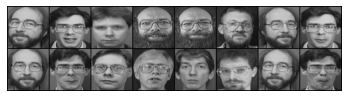

[[0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]]


In [4]:
# 看看数据集
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        batch_size=8)
example_batch = next(iter(vis_dataloader)) #生成一批图像
#其中example_batch[0] 维度为torch.Size([8, 1, 100, 100])

#torch.cat是将两个张量（tensor）拼接在一起

concatenated = torch.cat((example_batch[0],example_batch[1]),0) 
imshow(torchvision.utils.make_grid(concatenated, nrow=8))
print(example_batch[2].numpy())

## 模型和损失函数

In [5]:
#搭建模型
'''
对矩阵进行四周填充
pad = nn.ReflectionPad2d(3)
添加三圈
pad = nn.ReflectionPad2d(1,2,3,4,)
左边一列，右边两列，上面三行，下面四行
'''
class SiameseNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        #Sequential 一个容器
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),

            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2
    
    
#自定义ContrastiveLoss
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss_contrastive

torch.Size([32, 1, 100, 100])
tensor([[[0.5098, 0.5176, 0.5098,  ..., 0.4706, 0.4824, 0.4824],
         [0.5176, 0.5216, 0.5137,  ..., 0.4745, 0.4745, 0.4667],
         [0.5137, 0.5137, 0.5059,  ..., 0.4784, 0.4824, 0.4824],
         ...,
         [0.4078, 0.4118, 0.4235,  ..., 0.2118, 0.2000, 0.2078],
         [0.4392, 0.4471, 0.4824,  ..., 0.2078, 0.1961, 0.2118],
         [0.4314, 0.4784, 0.5020,  ..., 0.2039, 0.1961, 0.2039]]])
torch.Size([1, 100, 100])


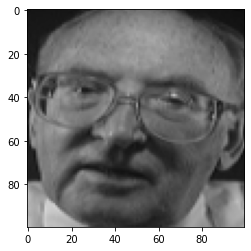

In [6]:
## 训练之前看看
import cv2
def tensor_to_img(tensor):
    img = tensor.mul(255).byte()
    #img = img.cpu().numpy().squeeze(0).transpose((1, 2, 0))
    img = img.cpu().numpy().transpose((1, 2, 0))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure()
    plt.imshow(img)
#     if title is not None:
#         plt.title(title)
    plt.pause(0.001)

for epoch in range(0, train_number_epochs):
    if epoch==1:
        for i, data in enumerate(train_dataloader, 0):
            if i==1:
                img0, img1 , label = data
                print(img0.shape)
                print(img0[1])
                print(img0[1].shape)
                tensor_to_img(img0[31])


## 训练

Epoch number: 0 , Current loss: 4.5205

Epoch number: 1 , Current loss: 3.4860

Epoch number: 2 , Current loss: 0.7252

Epoch number: 3 , Current loss: 0.7245

Epoch number: 4 , Current loss: 3.2072

Epoch number: 5 , Current loss: 1.6406

Epoch number: 6 , Current loss: 0.7516

Epoch number: 7 , Current loss: 0.5381

Epoch number: 8 , Current loss: 0.1918

Epoch number: 9 , Current loss: 0.3122

Epoch number: 10 , Current loss: 0.6296

Epoch number: 11 , Current loss: 0.4777

Epoch number: 12 , Current loss: 0.1394

Epoch number: 13 , Current loss: 0.1095

Epoch number: 14 , Current loss: 0.2633

Epoch number: 15 , Current loss: 0.1290

Epoch number: 16 , Current loss: 0.1034

Epoch number: 17 , Current loss: 1.2021

Epoch number: 18 , Current loss: 0.0669

Epoch number: 19 , Current loss: 0.1017

Epoch number: 20 , Current loss: 0.3682

Epoch number: 21 , Current loss: 0.0893

Epoch number: 22 , Current loss: 0.1181

Epoch number: 23 , Current loss: 0.1818

Epoch number: 24 , Current

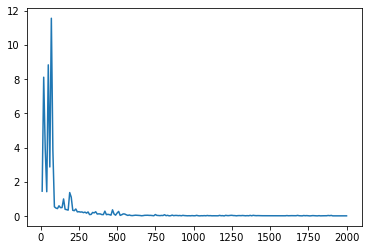

In [7]:
net = SiameseNetwork().cuda() #定义模型且移至GPU
criterion = ContrastiveLoss() #定义损失函数
optimizer = optim.Adam(net.parameters(), lr = 0.0005) #定义优化器

counter = []
loss_history = [] 
iteration_number = 0

train_number_epochs=100
#开始训练
for epoch in range(0, train_number_epochs):
    for i, data in enumerate(train_dataloader, 0):
        
        img0, img1 , label = data
        #img0维度为torch.Size([32, 1, 100, 100])，32是batch，label为torch.Size([32, 1])
        img0, img1 , label = img0.cuda(), img1.cuda(), label.cuda() #数据移至GPU
        optimizer.zero_grad()
        output1,output2 = net(img0, img1)
        loss_contrastive = criterion(output1, output2, label)
        loss_contrastive.backward()
        optimizer.step()
        if i % 10 == 0 :
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
    print("Epoch number: {} , Current loss: {:.4f}\n".format(epoch,loss_contrastive.item()))
    
show_plot(counter, loss_history)

## 测试

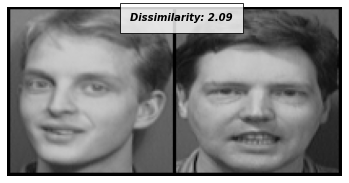

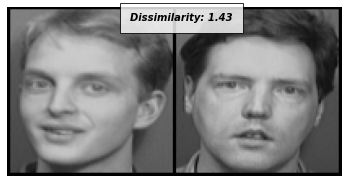

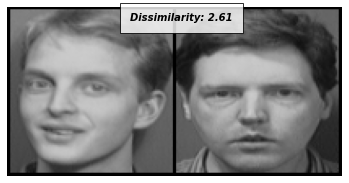

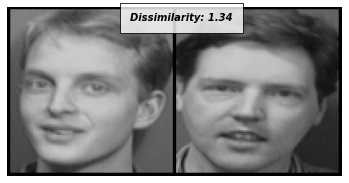

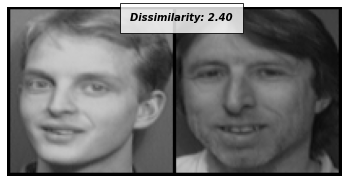

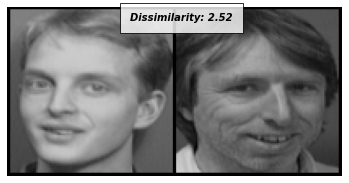

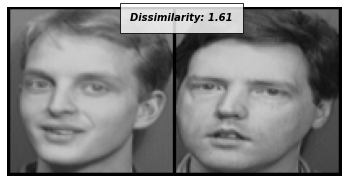

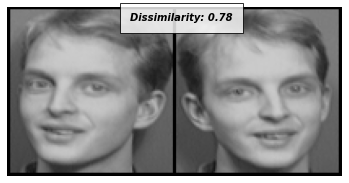

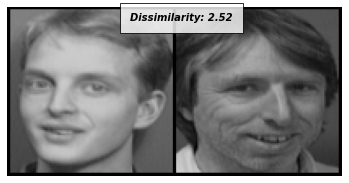

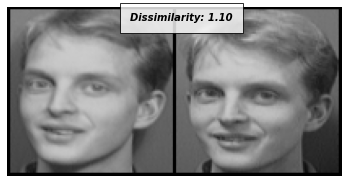

In [8]:
#定义测试的dataset和dataloader

#定义文件dataset
testing_dir = "./data/faces/testing/"  #测试集地址
folder_dataset_test = torchvision.datasets.ImageFolder(root=testing_dir)

#定义图像dataset
transform_test = transforms.Compose([transforms.Resize((100,100)), 
                                     transforms.ToTensor()])
siamese_dataset_test = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transform_test,
                                        should_invert=False)

#定义图像dataloader
test_dataloader = DataLoader(siamese_dataset_test,
                            shuffle=True,
                            batch_size=1)


#生成对比图像
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

for i in range(10):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    output1,output2 = net(x0.cuda(),x1.cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))

# 保存模型

In [12]:
#只保存参数
torch.save(net.state_dict(),"model_param.pth")

In [13]:
#保存模型和参数
torch.save(net, 'model_all.pth')  # 保存整个神经网络的结构和模型参数